In [1]:
import pandas as pd
import numpy as np

In [2]:
#paths 
newdata_path=(r'c:\\Users\\manos\\OneDrive - Vrije Universiteit Amsterdam\\VU\\B4TM\\Data\\newdata_start_end_nclones_combined.csv')

In [3]:
newdata = pd.read_csv(newdata_path,sep=';' )

In [4]:
newdata

,Unnamed: 0,Sample,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,...,23_66,23_67,23_68,23_69,23_70,23_71,23_72,23_73,23_74,Subgroup
0,0,Array.129,0,0,0,0,0,0,0,0,...,2,2,2,0,1,1,1,1,1,HER2+
1,1,Array.34,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,HR+
2,2,Array.67,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,HR+
3,3,Array.24,0,0,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,Triple Neg
4,4,Array.22,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,Triple Neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,Array.10,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,HER2+
96,96,Array.123,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,HR+
97,97,Array.100,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,HR+
98,98,Array.134,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,HR+


In [5]:
#drop Unnamed coll
df = newdata.drop('Unnamed: 0', axis=1)
#make sample col as index
df = df.set_index('Sample')

In [6]:
#seperate labels from data
X=df.iloc[:,0:-1]
y=df.iloc[:,-1]

Keep only the Fetured selected columns with murv 

In [ ]:
#commnent out only one of the selected features and run whole script 
X=X[['17_144', '22_53', '17_173','12_87','22_34','6_58','5_58','12_96','6_140','3_92','17_179','3_115','12_86','17_171','5_80','6_138','16_77']]

Keep only the Feture selected cols with GDB

In [8]:
#X=X[['17_144', '22_34','22_53','5_80','14_99','4_110','1_59','15_24','15_23','8_64','1_195','11_163','8_63','11_164','1_227','13_15','6_12']]



One way to format your data for input into an LSTM model is to treat each instance as a single timestep with multiple features. In this case, you would reshape your data to have shape (n_samples, 1, n_features) where n_samples is the number of instances in your dataset and n_features is the number of features (i.e., counts of DNA) in each instance. Here’s an exampl

In [9]:
#convert to df to np array
X_arr=X.values
#convert values to float
X_fl = X_arr.astype('float32')
# Reshape your data to have shape (n_samples, 1, n_features)
X= np.reshape(X_fl, (X_fl.shape[0],1, X_fl.shape[1] ))


In [10]:
X.shape

(100, 1, 17)

In [11]:
from sklearn.preprocessing import OneHotEncoder

# Create OneHotEncoder object
encoder = OneHotEncoder()

# Fit and transform data
y = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

C:\Users\manos\AppData\Local\Temp\ipykernel_35868\2230922241.py:32: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


2/2 [==============================] - 0s 7ms/step - loss: 0.4409 - accuracy: 0.7879 - auc: 0.9490 - recall: 0.7879 - precision: 0.7879


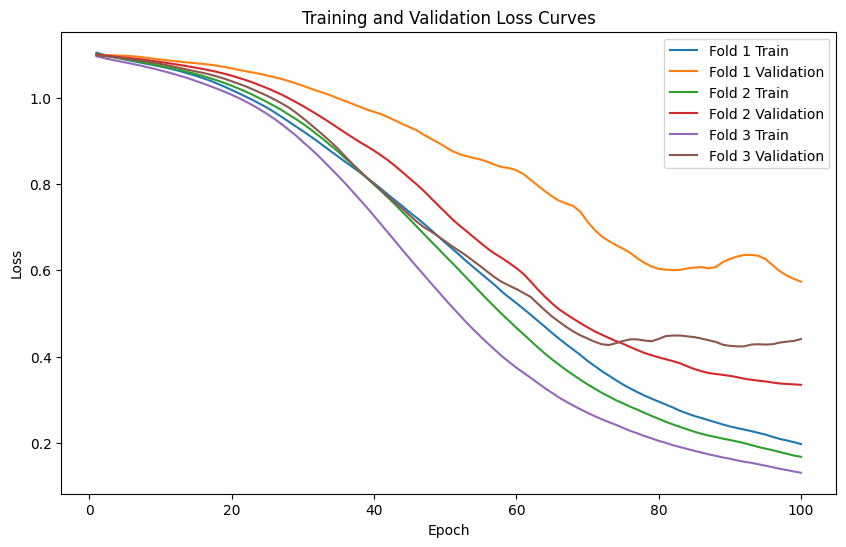

In [12]:
import keras.backend as K
from keras.callbacks import History
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold
from keras.layers import Dropout
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score

timesteps = X.shape[1]
input_dim = X.shape[2]
n_classes = 3
input_shape = (timesteps, input_dim)



def create_model(num_layers=1, units1=32, units2=32, optimizer='adam', dropout_rate=0.0):
    model = Sequential()
    for _ in range(num_layers - 1):
        model.add(LSTM(units=units1, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units2, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer,
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision'])
    return model


# Create a KerasClassifier wrapper for the Keras model
model = KerasClassifier(build_fn=create_model)

#define the hyperparameters to search over
param_grid = {
    'num_layers': [1, 2],  # Number of LSTM layers
    'units1': [10, 30, 50],  # Number of units in each layer
    'units2': [10, 30, 50], 
    'optimizer': ['adam', 'rmsprop', 'sgd']  # Different optimizers to try
}



# define the inner and outer cross-validation folds
inner_cv = KFold(n_splits=10, shuffle=True)
outer_cv = KFold(n_splits=3, shuffle=True)

# perform a grid search over the hyperparameters using nested cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv)
grid_search.fit(X, y)
best_params = grid_search.best_params_

# evaluate the best model on the outer cross-validation folds and plot loss curves
scores = []
val_loss_curves = []
loss_curves = []
for train_index, test_index in outer_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    best_model = create_model(**best_params)
    
    # asdd callbacks to track loss during training
    history = best_model.fit(X_train, y_train, verbose=0, epochs=100, validation_data=(X_test, y_test),
                             callbacks=[History()])
    
   #append loss curves to the lists
    loss_curves.append(history.history['loss'])
    val_loss_curves.append(history.history['val_loss'])
    
    score = best_model.evaluate(X_test, y_test)
    scores.append(score)

# plot loss curves
plt.figure(figsize=(10, 6))
for i, (loss_curve, val_loss_curve) in enumerate(zip(loss_curves, val_loss_curves)):
    epoch_nums = np.arange(1, len(loss_curve) + 1)
    plt.plot(epoch_nums, loss_curve, label=f"Fold {i+1} Train")
    plt.plot(epoch_nums, val_loss_curve, label=f"Fold {i+1} Validation")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


    

In [14]:
import numpy as np


# Create a list to store individual metrics
accuracies = []
auc=[]
recall=[]
precision=[]
# Append the metrics to list, row[0] is loss
for row in scores:
    accuracies.append(row[1])
    auc.append(row[2])
    recall.append(row[3])
    precision.append(row[4])
# Calculate the mean of the metrics
mean_accuracy= np.mean(accuracies)
mean_auc= np.mean(auc)
mean_recall= np.mean(recall)
mean_precision= np.mean(precision)
mean_f1=(mean_precision * mean_recall)/(mean_precision + mean_recall)
print('Mean Accuracy:',mean_accuracy,
      '\nMean AUC:',mean_auc,
      '\nMean Recall:',mean_recall,
      '\nMean Precision:',mean_precision,
      '\nMean F1: ', mean_f1)

print('Best Parameters',best_params)

Mean Accuracy: 0.8401663899421692 
Mean AUC: 0.9447489976882935 
Mean Recall: 0.8006535967191061 
Mean Precision: 0.8536656896273295 
Mean F1:  0.413155133012628
Best Parameters {'num_layers': 2, 'optimizer': 'adam', 'units1': 50, 'units2': 10}
